# How To Compute Volatility 6 Ways Most People Don’t Know
I’m going to show you 6 ways to compute statistical volatility in [Python](https://pyquantnews.com/python/).

The first way you’ve probably heard of. The other 5 may be new to you.

Statistical volatility (also called historic or realized volatility) is a measurement of how much the price or returns of stock value. It’s used to optimize portfolios, detect regime changes, and price derivatives. The most common way to measure statistical volatility is the standard deviation.

Unfortunately, there are some downsides to using standard deviation that most people don’t consider.

Before I show you how to compute volatility in 6 different ways, let’s get setup.

## Stock Price Data
First, we’ll use the excellent <i>yFinance</i> library to grab some stock price data. We’ll also import the <i>math</i> and <i>NumPy</i> libraries.

In [1]:
import math
import numpy as np
import pandas as pd

from openbb_terminal.sdk import openbb

In [2]:
data: pd.DataFrame = openbb.stocks.load("AAPL", start_date="2017-01-01", end_date="2022-06-30")

Loading Daily data for AAPL with starting period 2017-01-03.

In [3]:
returns = (data["Adj Close"] / data["Adj Close"].shift(1)) - 1

One line of code and we have four years of AAPL data. What a great time to be alive.

A quick plot of the daily close shows us the price chart of Apple.

<AxesSubplot: xlabel='date'>

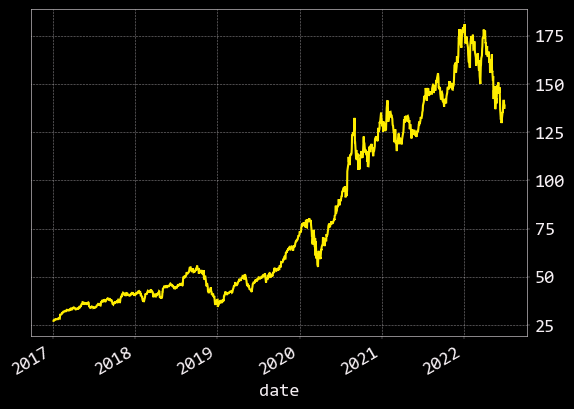

In [4]:
data['Adj Close'].plot()

## Parkinson
Parkinson’s volatility uses the stock’s high and low price of the day rather than just close to close prices. It’s useful to capture large price movements during the day.

In [5]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

We take the price data and compute a 30-day rolling volatility metric that we can plot.



<AxesSubplot: xlabel='date'>

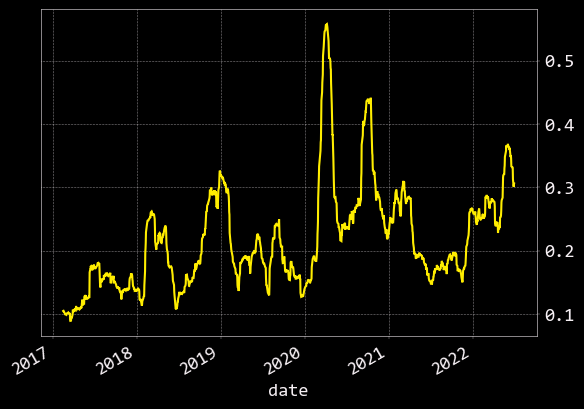

In [6]:
parkinson(data).plot()

## Garman-Klass
Garman-Klass volatility extends Parkinson’s volatility by taking into account the opening and closing price. As markets are most active during the opening and closing of a trading session, it makes volatility estimation more accurate.

In [7]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:



<AxesSubplot: xlabel='date'>

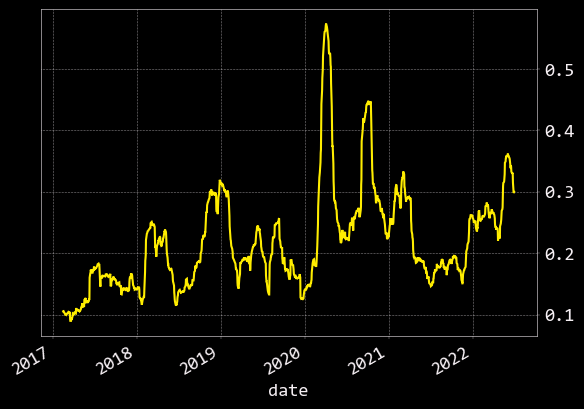

In [8]:
garman_klass(data).plot()

## Hodges-Tompkins
Hodges-Tompkins volatility is a bias correction for estimation using an overlapping data sample that produces unbiased estimates and a substantial gain in efficiency.



In [9]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

Let’s plot it:



<AxesSubplot: xlabel='date'>

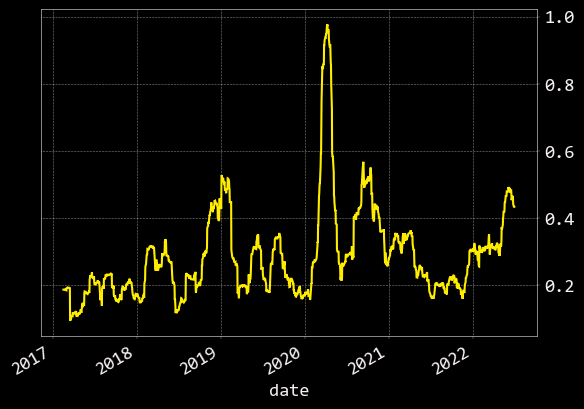

In [10]:
hodges_tompkins(data).plot()

## Rogers-Satchell
Rogers-Satchell is an estimator for measuring the volatility of securities with an average return not equal to zero. Unlike Parkinson and Garman-Klass estimators, Rogers-Satchell incorporates a drift term (mean return not equal to zero).

In [11]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:



<AxesSubplot: xlabel='date'>

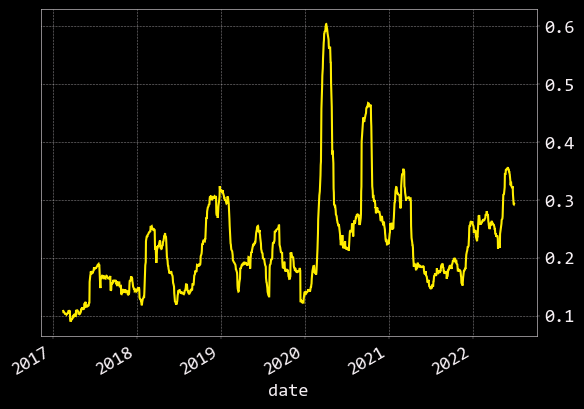

In [12]:
rogers_satchell(data).plot()

## Yang-Zhang
Yang-Zhang volatility is the combination of the overnight (close-to-open volatility), a weighted average of the Rogers-Satchell volatility and the day’s open-to-close volatility.

In [13]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:



<AxesSubplot: xlabel='date'>

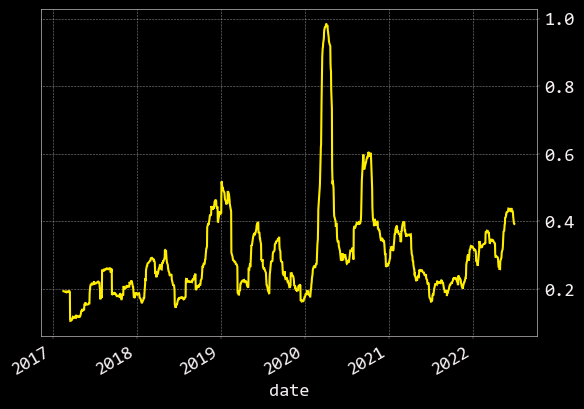

In [14]:
yang_zhang(data).plot()

## Standard Deviation
We’ll start with the standard deviation. Standard deviation measures how widely returns are dispersed from the average return. It’s the most common (and biased) estimator of volatility.



In [15]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:



<AxesSubplot: xlabel='date'>

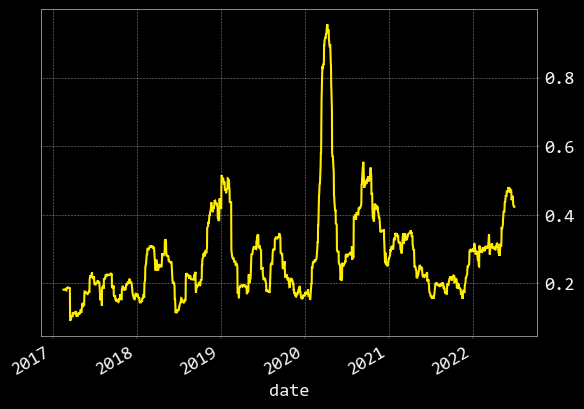

In [16]:
standard_deviation(data).plot()

## Which One Do I Use?
Each measure has tradeoffs you must consider. Most practitioners will choose the one they believe captures the information they think is relevant. In a future issue, I’ll show you how to build a simple trading strategy based on different volatility measures.